In [1]:
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
import math
import copy
import matplotlib.pyplot as plt

## Load data

This uses the discharge-voltage curves at each cycle as raw data. Dimensionality is $(100,1000)$, with 100 cycles and 1000 voltage steps at which discharge is measured

In [2]:
data = pickle.load(open(r'../Data/deltaQ_cycles.pkl', 'rb'))

In [827]:
data["b1c1"]

{'cycle_life': 2160.0,
 'DeltaQ_logVars': array([1.30990768e-05, 4.54876942e-05, 1.61079288e-05, 2.69828039e-05,
        1.52879197e-05, 7.44972457e-06, 6.18154933e-06, 2.43796445e-05,
        1.03301510e-05, 2.97377879e-05, 2.33533042e-05, 3.36365401e-05,
        3.29679982e-05, 2.84812542e-05, 3.61955571e-05, 4.21656009e-05,
        2.65591091e-05, 2.72974956e-05, 1.82752738e-05, 2.84577561e-05,
        2.59956232e-05, 1.52640681e-05, 1.64507199e-05, 1.65898173e-05,
        1.55944150e-05, 2.39244889e-05, 2.28800379e-05, 3.90623092e-05,
        2.53873873e-05, 2.15221381e-05, 4.62939031e-05, 6.66817456e-05,
        2.48862503e-05, 2.66145580e-05, 4.81881678e-05, 2.20008665e-05,
        2.02312608e-05, 1.19843708e-05, 1.10751226e-05, 1.95385663e-05,
        6.01342926e-06, 2.05228893e-05, 1.96734911e-05, 8.92065797e-06,
        1.34843051e-05, 2.54005341e-05, 3.04152667e-05, 2.62765892e-05,
        1.47949515e-05]),
 'DeltaQ_mins': array([-0.01199224, -0.03775483, -0.00602078, -0.0253

In [49]:
y = np.zeros(124)

x = np.zeros((124, 49, 3))
for i, cell in enumerate(data.keys()):
    x[i, :, 0] = np.log10(data[cell]["DeltaQ_logVars"])
    x[i, :, 1] = np.log10(-data[cell]["DeltaQ_mins"])
    x[i, :, 2] = data[cell]["DeltaQ_means"]
    y[i] = np.log10(data[cell]["cycle_life"])


In [21]:
np.shape(x) # 124 batteries, 99 cycles, discharge measured at 1000 voltage steps per cycle

(124, 49, 3)

In [5]:
np.shape(y)

(124,)

In [50]:
# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)

## Split into train/test sets

In [7]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  5,  7,  9, 11, 13, 15, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123])

In [51]:
train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
test = TensorDataset(torch.Tensor(x[test_ind]),torch.Tensor(y[test_ind]))
stest = TensorDataset(torch.Tensor(x[secondary_ind]),torch.Tensor(y[secondary_ind]))

## Transformer model

In [70]:
# parameters
d_model = 1000
nhead = 8
batch_size = 3
nepoch = 1
batch_first = True

In [81]:
class FullModel(torch.nn.Module):

    def __init__(self, num_heads = 1, num_layers = 1, d_model = 1, cycles = 49):
        super(FullModel, self).__init__()

        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
           d_model=d_model, nhead=num_heads,
           dim_feedforward=int(d_model), dropout=0)

        self.position_embeddings = nn.Parameter(torch.randn(cycles, d_model))
        self.cls = nn.Parameter(torch.randn(cycles, 1))
        self.transformer = nn.TransformerEncoder(
                                encoder_layer=self.transformer_encoder_layer,
                                num_layers=num_layers)
        self.linear = nn.Linear(d_model, 1)
        self.initialize_parameters()

    def initialize_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        # Add position embedding into patch embedding
        # x = self.conv(x)
        # x = torch.concatenate((self.cls, x), dim=1)
        # x = x + self.position_embeddings
        x = self.transformer(x)
        x = torch.sum(x, dim = 0)
        x = self.linear(x)
        return x

In [93]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Load nodel, loss function, and optimizer
# model = FullModel(d_model=3).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)


model.train()

# # Fine tuning loop
for i in range(100):
    total_loss_train = 0.0
    total_real_loss = 0.0

    for cell in train:
        train_input, train_label = cell
        output = model(train_input.to(device))
        log_loss = criterion(output, train_label)
        real_loss = (10**train_label.item()-10**output.item())**2

        # print(i, output, train_label, loss)

        total_loss_train += log_loss.item()
        total_real_loss += real_loss

        log_loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    if (i+1)%10 == 0: 
        print(f'Epochs: {i + 1} | rmse: {np.sqrt(total_real_loss / len(train)): .3f}')

Epochs: 10 | rmse:  216.713
Epochs: 20 | rmse:  216.524
Epochs: 30 | rmse:  216.508
Epochs: 40 | rmse:  216.515
Epochs: 50 | rmse:  216.535
Epochs: 60 | rmse:  216.550
Epochs: 70 | rmse:  216.567
Epochs: 80 | rmse:  216.582
Epochs: 90 | rmse:  216.599
Epochs: 100 | rmse:  216.612


In [94]:
model.eval()

total_real_loss = 0.0
for cell in test:
    test_input, test_label = cell
    output = model(test_input.to(device))
    real_loss = (10**test_label.item()-10**output.item())**2

    total_real_loss += real_loss

print(f'Test rmse: {np.sqrt(total_real_loss / len(train)): .3f}')

total_real_loss = 0.0
for cell in stest:
    test_input, test_label = cell
    output = model(test_input.to(device))
    real_loss = (10**test_label.item()-10**output.item())**2

    total_real_loss += real_loss

print(f'S Test rmse: {np.sqrt(total_real_loss / len(train)): .3f}')

Test rmse:  271.787
S Test rmse:  327.827


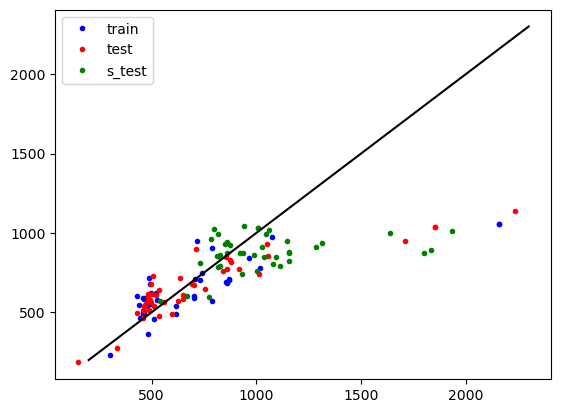

In [95]:
for i in range(len(train)):
    a, b = train[i]
    if i == 0: plt.plot(10**b, 10**model.forward(a).detach().numpy(), ".b", label = "train") 
    plt.plot(10**b, 10**model.forward(a).detach().numpy(), ".b")

for i in range(len(test)):
    a, b = test[i]
    if i == 0: plt.plot(10**b, 10**model.forward(a).detach().numpy(), ".r", label = "test") 
    plt.plot(10**b, 10**model.forward(a).detach().numpy(), ".r")

for i in range(len(stest)):
    a, b = stest[i]
    if 10**model.forward(a).detach().numpy() > 1e7: print(i)
    if i == 0: plt.plot(10**b, 10**model.forward(a).detach().numpy(), ".g", label = "s_test") 
    plt.plot(10**b, 10**model.forward(a).detach().numpy(), ".g")

xs = np.linspace(200, 2300, 5)
plt.plot(xs, xs, "k")
plt.legend()
plt.show()

## Testing the tranformer encoder regression

In [438]:
import matplotlib.pyplot as plt

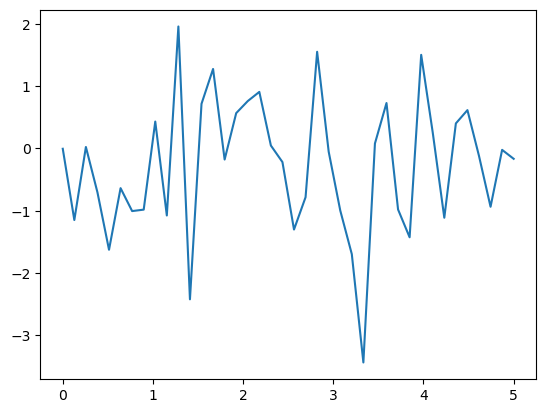

In [773]:
processes = []
means = []

for i in range(500):
    xs = np.linspace(0, 5, 40)
    v = np.random.uniform(1, 5)
    processes.append(np.random.normal(0, v, 40))
    means.append(v)
    
plt.plot(xs, processes[50])

train = TensorDataset(torch.Tensor(processes[:400]),torch.Tensor(means[:400]))
test = TensorDataset(torch.Tensor(processes[400:]),torch.Tensor(means[400:]))

In [794]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Load nodel, loss function, and optimizer
model = FullModel(d_model=40, cycles=1, num_heads=2, num_layers=2).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=4e-5)

model.train()

# # Fine tuning loop
for i in range(100):
    total_loss_train = 0.0
    total_loss_test = 0.0

    for cell in train:
        train_input, train_label = cell
        output = model.forward(train_input.expand((1, 40)).to(device))
        loss = criterion(output, train_label)
        

        # print(i, output, train_label, loss)
        total_loss_train += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    for cell in test:
        test_input, test_label = cell
        test_output = model(test_input.expand((1, 40)).to(device))
        test_loss = criterion(test_output, test_label)
        

        # print(i, output, train_label, loss)
        total_loss_test += test_loss.item()


    print(f'Epochs: {i + 1} | rmse: {np.sqrt(total_loss_train / len(train)): .3f} | rmse_test: {np.sqrt(total_loss_test / len(test)): .3f}')

model.eval();

Epochs: 1 | rmse:  2.393 | rmse_test:  1.805
Epochs: 2 | rmse:  1.557 | rmse_test:  1.529
Epochs: 3 | rmse:  1.400 | rmse_test:  1.443
Epochs: 4 | rmse:  1.322 | rmse_test:  1.387
Epochs: 5 | rmse:  1.263 | rmse_test:  1.345
Epochs: 6 | rmse:  1.216 | rmse_test:  1.314
Epochs: 7 | rmse:  1.176 | rmse_test:  1.290
Epochs: 8 | rmse:  1.142 | rmse_test:  1.271
Epochs: 9 | rmse:  1.111 | rmse_test:  1.255
Epochs: 10 | rmse:  1.083 | rmse_test:  1.242
Epochs: 11 | rmse:  1.056 | rmse_test:  1.231
Epochs: 12 | rmse:  1.031 | rmse_test:  1.222
Epochs: 13 | rmse:  1.006 | rmse_test:  1.215
Epochs: 14 | rmse:  0.982 | rmse_test:  1.208
Epochs: 15 | rmse:  0.959 | rmse_test:  1.203
Epochs: 16 | rmse:  0.936 | rmse_test:  1.198
Epochs: 17 | rmse:  0.914 | rmse_test:  1.194
Epochs: 18 | rmse:  0.893 | rmse_test:  1.190
Epochs: 19 | rmse:  0.871 | rmse_test:  1.186
Epochs: 20 | rmse:  0.849 | rmse_test:  1.183
Epochs: 21 | rmse:  0.827 | rmse_test:  1.180
Epochs: 22 | rmse:  0.805 | rmse_test:  1.1

KeyboardInterrupt: 

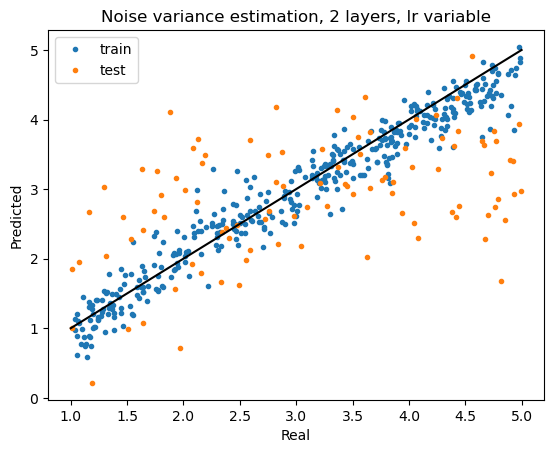

In [795]:
predicted =[]
labels = []
for cell in train:
    train_input, train_label = cell
    predicted.append(model(train_input.expand((1, 40)).to(device)).detach().numpy())
    labels.append(train_label)

plt.plot(labels, predicted, ".", label = "train")
plt.title("Noise variance estimation, 2 layers, lr variable")
plt.xlabel("Real")
plt.ylabel("Predicted")
predicted =[]
labels = []
for cell in test:
    train_input, train_label = cell
    predicted.append(model(train_input.expand((1, 40)).to(device)).detach().numpy())
    labels.append(train_label)

plt.plot(labels, predicted, ".", label = "test")
xs = np.linspace(1, 5, 10)
plt.plot(xs, xs, "k")
plt.legend();

torch.Size([1, 400])


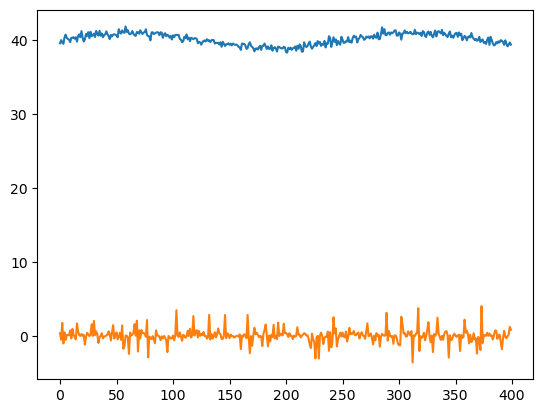

In [164]:
o = model.transformer(test[0][0].expand((1, 400)))
print(o.size())
plt.plot(test[0][0])
plt.plot(o[0].detach().numpy())